<a href="https://colab.research.google.com/github/HaniaRangel/SIM_MAT/blob/main/Proyecto1Simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Optimización de Parámetros Geométricos de Nanopartículas para la Liberación Controlada y Sostenida de Fármacos**  
Ignacio Arredondo, Edgar Estrada, Hania Rangel


##**Objetivos**

**Objetivo General**
* Determinar el conjunto de parámetros geométricos para formular una nanopartícula transportadora con un perfil de liberación de un fármaco (concentración vs. tiempo) que sea sostenido y terapéuticamente efectivo, minimizando la dosis total.

**Objetivos Específicos**
1. Modelar el proceso de liberación del fármaco desde la nanopartícula, utilizando el modelo de Korsmeyer-Peppas, para establecer una función de concentración-tiempo.

1. Definir y formular la función objetivo (ej. minimización del error cuadrático medio) que cuantifique la desviación entre el perfil de liberación modelado y un perfil de liberación ideal (terapéutico).

1. Implementar el modelo y la función objetivo en Python, utilizando SymPy para la formulación simbólica y NumPy para los cálculos numéricos.

1. Utilizar la librería scipy.optimize para resolver el problema, encontrando los valores óptimos de las variables de diseño (ej. tamaño de la nanopartícula, grosor del recubrimiento).

1. Visualizar el perfil de liberación óptimo y compararlo con perfiles subóptimos usando Matplotlib.



##**Modelo que representa el problema**
El modelo de Korsmeyer-Peppas se ha utilizado con éxito para describir la cinética de liberación de fármacos desde liposomas. En este estudio, los datos experimentales de los estudios se ajustan a la ecuación (denominada ecuación de Korsmeyer-Peppas):
$$\frac{M_t}{M_\infty}=k \cdot t^n$$

En esta ecuación, $\frac{M_t}{M_\infty}$ representa el fármaco permeado fraccional, $t$ es el tiempo, $k$ es la constante de transporte, y $n$ es el exponente de transporte. La constante de liberación $k$ proporciona principalmente información sobre la formulación del fármaco, como las características estructurales de los nanotransportadores, mientras que $n$ es importante ya que está relacionada con el mecanismo de liberación del fármaco (Sahoo et al., 2019).



El objetivo es minimizar la diferencia entre la concentración liberada y una concentración deseada, $C_{deseada}$, que representa el nivel terapéutico constante durante un tiempo $T$.

**Función Objetivo: Minimizar el Error Cuadrático Medio (MSE) entre el perfil de liberación ideal y el perfil modelado.**
$$
min f(k,n)=\sum_{i=1}^{N}[C_{modelo}(t_i,k,n)-C_{deseada}]^2
$$

**Restricciones:**
* Radio de la partícula ($r$):
$10\;\mathrm{nm}\leq{r}\leq{200}\;\mathrm{nm}$
* Exponente de difusión ($n$):
$0.43\leq{n}\leq{1.0}$
* La concentración total liberada debe de ser mayor en todo el tiempo $T$:
$C_{modelo}(t,k,n)\geq{C_{min}}$ para todo $t\;\epsilon\;[0,T]$

**Parámetros**
* Variables de Decisión: $k$ y $n$.

* Parámetros Fijos: $C_{deseada}$ (concentración terapéutica constante), $T$ (duración de la terapia).

##**Solución del problema de optimización**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sym

In [ ]:
# Definición de constantes y parámetros

T_MAX=10                            #duración del tratamiento en horas
C_DESEADA=0.8                       #objetivo de la optimización
C_MIN_EFECTIVA=0.7                  #restricción terapéutica
tiempo=np.linspace(0.1,T_MAX,50)

In [ ]:
# Modelo de liberación (Korsmeyer-Peppas)

def modelo_korsmeyer_peppas(t,k,n):
    liberacion=k*(t**n)
    return np.clip(liberacion,0,1.0)
# se usa np.clip para solo obtener valores en rango (1 es máx porque es el 100% de la liberacion del farmaco)

In [ ]:
# Minimización del error cuadrático medio (MSE)

def funcion_objetivo_mse(parametros,t,c_deseada):
    k,n=parametros #'parametros' es un array [k, n]
    c_modelo=modelo_korsmeyer_peppas(t,k,n)
    # Cálculo del MSE
    mse=np.mean((c_modelo-c_deseada)**2)
    return mse

In [ ]:
# Restricciones de en las variables de diseño [k, n]
bounds = [
    (0.01,5.0),  #límite para k
    (0.43,1.0)   #límite para n
]

# Restricción de desigualdad (Concentración Mínima Efectiva)
def restriccion_terapeutica(parametros,t,c_min):
    #Restricción de desigualdad: C_modelo - C_min_efectiva >= 0
    k,n=parametros
    c_modelo=modelo_korsmeyer_peppas(t,k,n)
    # Evaluamos la restricción en el punto de menor liberación (t[0])
    c_t0=c_modelo[0]
    return c_t0-c_min

# Objeto de restricciones para scipy.optimize
restricciones = [
    {'type':'ineq',
     'fun':restriccion_terapeutica,
     'args':(tiempo, C_MIN_EFECTIVA)}
]

In [ ]:
# Punto de partida (datos arbitrarios para 'k' y 'n')
parametros_iniciales=[0.5,0.5]

# Formato
resultado_optimo=minimize(
    fun=funcion_objetivo_mse,
    x0=parametros_iniciales,
    args=(tiempo, C_DESEADA),
    method='SLSQP',
    bounds=bounds,
    constraints=restricciones,
    options={'disp': True}
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.039201129176619484
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2


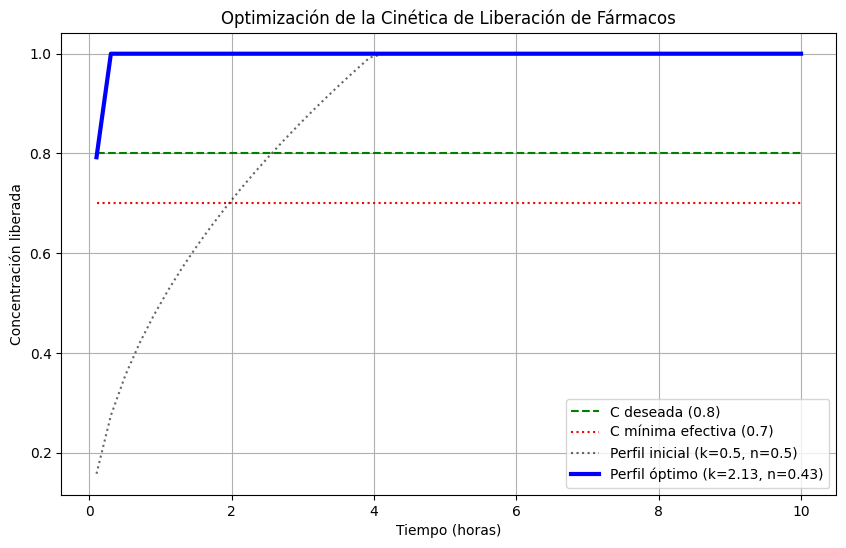

In [50]:
# Gráfico
c_optimo = modelo_korsmeyer_peppas(tiempo, k_optimo, n_optimo)
c_inicial = modelo_korsmeyer_peppas(tiempo, *parametros_iniciales)

plt.figure(figsize=(10, 6))
plt.plot(tiempo, C_DESEADA * np.ones_like(tiempo), 'g--', label=f'C deseada ({C_DESEADA})')
plt.plot(tiempo, C_MIN_EFECTIVA * np.ones_like(tiempo), 'r:', label=f'C mínima efectiva ({C_MIN_EFECTIVA})')
plt.plot(tiempo, c_inicial, 'k:', alpha=0.6, label='Perfil inicial (k=0.5, n=0.5)')
plt.plot(tiempo, c_optimo, 'b-', linewidth=3, label=f'Perfil óptimo (k={k_optimo:.2f}, n={n_optimo:.2f})')

plt.title('Optimización de la Cinética de Liberación de Fármacos')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Concentración liberada')
plt.legend()
plt.grid()

In [ ]:
# Extracción de los resultados
k_optimo,n_optimo=resultado_optimo.x
mse_final=resultado_optimo.fun

print("\n--- Resultados de la Optimización ---")
print(f"Éxito de la optimización: {resultado_optimo.success}")
print(f"k óptimo (velocidad/geometría): {k_optimo:.4f}")
print(f"n óptimo (mecanismo/difusión): {n_optimo:.4f}")
print(f"MSE mínimo (error cuadrático): {mse_final:.6f}")
c_t0_optimo = modelo_korsmeyer_peppas(tiempo[0], k_optimo, n_optimo)
print(f"C(t=0.1) óptima: {c_t0_optimo:.4f}. Restricción: C >= {C_MIN_EFECTIVA}")


--- Resultados de la Optimización ---
Éxito de la optimización: True
k óptimo (velocidad/geometría): 2.1330
n óptimo (mecanismo/difusión): 0.4300
MSE mínimo (error cuadrático): 0.039201
C(t=0.1) óptima: 0.7925. Restricción: C >= 0.7


##**Conclusiones**
De la gráfica se puede concluír que para cumplir con el requisito de dosis inicial (restricción) y acercarse al perfil sostenido (función objetivo), necesitas una nanopartícula con una cinética dominada por difusión lenta ($n≈0.43$) y una alta constante de velocidad ($k≈2.133$) que garantice la liberación inmediata *mínima*.

El valor de $0.430000$ para $n$ está situado en límite inferior que definimos, indicando una difusión Fickiana, es decir, lo más lenta y sostenida posible. Este valor también indica que la partícula sea **esférica**.  

El valor de $k=2.1330$ es alto, ya que compensa el inicio lento de la difusión, e indica NP's de menor tamaño o mayor solubilidad.
La optimización lo estableció para cumplir que la $C$ siempre fuera mayor o igual a la $C$_$Mínima$ efectiva.

En cuando a la optimización para obtener el MSE mínimo, el valor bajo obtenido ($0.039201$) confirma que, con esos parámetros ($k$, $n$), el perfil de liberación óptimo se desvía muy poco de la curva constante y deseada de $C=0.8$.

En general, con el desarrollo de este proyecto nos fué posible desarrollar un código con el cual pudimos aplicar un problema con un tema relacionado con nuestra carrera, como lo es la liberación de fármacos, incluso si se requirió investigación extra y a fondo para poder cumplir con nuestros objetivos. Logramos llegar a la solución óptima de nuestro problema dados parámetros iniciales deseados.

##**Referencias**
Sahoo, S. A., Singh, B. K., Mishra, A. K., Singh, A. K., & Luthra, G. K. (2019). Pharmaceutical development and optimization of drug-loaded polymeric nanoparticles for controlled drug delivery: A comprehensive review. International Journal of Pharmaceutics, 563, 166–181.